In [163]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

from matplotlib.ticker import FormatStrFormatter


## Import ASHRAE Thermal Comfort Database 2

In [164]:
# Read metadata from Github
url_meta = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_metadata.csv"
df_meta = pd.read_csv(url_meta)

# Read database from Github
url_measurements = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_measurements_v2.1.0.csv.gz"
df_measurements = pd.read_csv(url_measurements)

<ipython-input-164-c67988f7a35f>:7: DtypeWarning: Columns (5,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_measurements = pd.read_csv(url_measurements)


In [165]:
# Merge building metadata and measurement data
df_data = df_measurements.merge(df_meta[['building_id', 'city', 'building_type', 'cooling_type', 'records', 'database']], on='building_id', how='left')

print('Total buildings:', len(df_data.building_id.unique()))
print('Total records:', len(df_data))

Total buildings: 809
Total records: 109033


### Data cleaning

In [166]:
# Merge two outdoor air temperature columns as a new column
df_data.loc[:, 't_out_combined'] = df_data.loc[:, 't_out_isd'].fillna(df_data.loc[:, 't_out'])
# Remove the two outdoor air temperature columns
df_data = df_data.drop(columns=['t_out_isd', 't_out'])

# Keep rows that simultaneously have data for all variables in cols 
def keep_rows(df, cols):
    df_new = df.dropna(subset=cols)
    print(f'Qualified buildings:', len(df_new['building_id'].unique()), cols)
    print(f'Qualified records:', len(df_new))
    return df_new

In [167]:
cols = ['t_out_combined', 'top', 'thermal_sensation']
df_data = keep_rows(df_data, cols).copy()

Qualified buildings: 553 ['t_out_combined', 'top', 'thermal_sensation']
Qualified records: 38467


## Estimation result on the first building in the dataset

In [227]:
# neutral temepratuer calculation example
df_data_1bldg = df_data[df_data['building_id'] == 1]
df_data_1bldg.head()

,index,record_id,building_id,timestamp,season,subject_id,age,gender,ht,wt,...,ppd,pmv_ce,ppd_ce,t_mot_isd,city,building_type,cooling_type,records,database,t_out_combined
0,0,1,1,1995-05-18T00:00:00Z,winter,10.0,NaN,female,NaN,NaN,...,10.2,0.38,8.0,17.4,sydney,office,mixed mode,170,1.0,16.295833
1,1,2,1,1995-05-18T00:00:00Z,winter,14.0,NaN,female,NaN,NaN,...,8.4,0.40,8.4,17.4,sydney,office,mixed mode,170,1.0,16.295833
2,2,3,1,1995-05-18T00:00:00Z,winter,15.0,NaN,female,NaN,NaN,...,5.1,-0.07,5.1,17.4,sydney,office,mixed mode,170,1.0,16.295833
3,3,4,1,1995-05-18T00:00:00Z,winter,17.0,NaN,female,NaN,NaN,...,7.0,0.14,5.4,17.4,sydney,office,mixed mode,170,1.0,16.295833
4,4,5,1,1995-05-18T00:00:00Z,winter,21.0,NaN,male,NaN,NaN,...,5.0,-0.06,5.1,17.4,sydney,office,mixed mode,170,1.0,16.295833


### linear regression method (a)

<ipython-input-327-75da2b196e23>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_1bldg['TSV_pred'] = lm_result.predict(df_data_1bldg['top'])


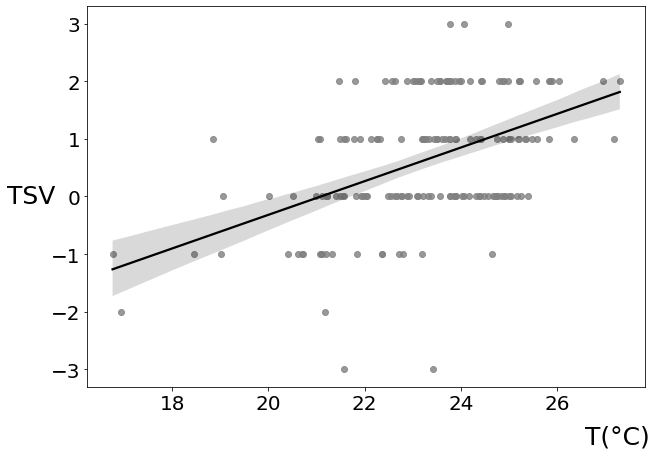

Neutral temperature is 21.1 degree Celsius.
80 percent acceptable temperature range is (18.2 ~ 24.0) degree Celsius.
90 percent acceptable temperature range is (19.4 ~ 22.8) degree Celsius.
p value: 1.2974572985470425e-10
                            OLS Regression Results                            
Dep. Variable:      thermal_sensation   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     47.03
Date:                Mon, 25 Sep 2023   Prob (F-statistic):           1.30e-10
Time:                        14:43:18   Log-Likelihood:                -237.80
No. Observations:                 169   AIC:                             479.6
Df Residuals:                     167   BIC:                             485.9
Df Model:                           1                                         
Covariance Type:            nonrobust                              

In [327]:

# regressing thermal sensation votes against temperature
lm_result = smf.ols(formula='thermal_sensation ~ top', data=df_data_1bldg).fit()

# add the prediction to the dataframe
df_data_1bldg['TSV_pred'] = lm_result.predict(df_data_1bldg['top'])
# plot the regression line
plt.figure(figsize=(10, 7))
sns.regplot(x='top', y='thermal_sensation', data=df_data_1bldg, scatter_kws={'color': 'grey'}, line_kws={'color': 'black'})
plt.xlabel('T(°C)', fontsize=25)
plt.ylabel('TSV', rotation=0, fontsize=25)
# plt.title('Regress thermal sensation votes on indoor temperature')

# Move y-axis label to the top and adjust the distance
ax = plt.gca()
ax.xaxis.set_label_coords(0.95, -0.1)
ax.yaxis.set_label_coords(-0.1, 0.47)

plt.xticks(fontsize=20)  # Rotate and set font size for x-axis tick labels
plt.yticks(fontsize=20)  # Set font size for y-axis tick labels

plt.grid(False)
plt.show()

# check whether the correaltion (slope) is significant
if lm_result.pvalues['top'] < 0.05:
    a = lm_result.params['top']
    b = lm_result.params['Intercept']
    neutral_temp = -b / a
    temp80_up = (0.85-b)/a
    temp80_low = (-0.85-b)/a
    temp90_up = (0.5-b)/a
    temp90_low = (-0.5-b)/a
    print('Neutral temperature is {:.1f} degree Celsius.'.format(neutral_temp))
    print('80 percent acceptable temperature range is ({:.1f}'.format(temp80_low), '~ {:.1f}) degree Celsius.'.format(temp80_up))
    print('90 percent acceptable temperature range is ({:.1f}'.format(temp90_low), '~ {:.1f}) degree Celsius.'.format(temp90_up))
else:
    print('The slope is not significant.')

# statistical anayalsis summary
print('p value:', lm_result.pvalues['top'])
print(lm_result.summary())


### linear regression method (b)

<ipython-input-326-709cb850d083>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_1bldg['top_pred'] = lm_result.predict(df_data_1bldg['thermal_sensation'])


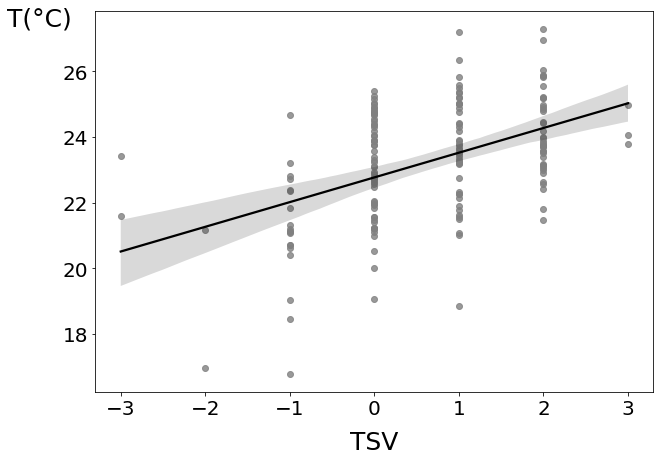

Neutral temperature is 22.8 degree Celsius.
80 percent acceptable temperature range is (22.1 ~ 23.4) degree Celsius.
90 percent acceptable temperature range is (22.4 ~ 23.1) degree Celsius.
p value: 1.297457298547297e-10
                            OLS Regression Results                            
Dep. Variable:                    top   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     47.03
Date:                Mon, 25 Sep 2023   Prob (F-statistic):           1.30e-10
Time:                        14:43:05   Log-Likelihood:                -317.89
No. Observations:                 169   AIC:                             639.8
Df Residuals:                     167   BIC:                             646.0
Df Model:                           1                                         
Covariance Type:            nonrobust                               

In [326]:
# regressing thermal sensation votes against temperature
lm_result = smf.ols(formula='top ~ thermal_sensation', data=df_data_1bldg).fit()

# add the prediction to the dataframe
df_data_1bldg['top_pred'] = lm_result.predict(df_data_1bldg['thermal_sensation'])
# plot the regression line
plt.figure(figsize=(10, 7))
sns.regplot(x='thermal_sensation', y='top', data=df_data_1bldg, scatter_kws={'color': 'grey'}, line_kws={'color': 'black'})
plt.xlabel('TSV', fontsize=25)
plt.ylabel('T(°C)', rotation=0, fontsize=25)
# plt.title('Regress thermal sensation votes on indoor temperature')

# Move y-axis label to the top and adjust the distance
ax = plt.gca()
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.1, 0.95)

plt.xticks(fontsize=20)  # Rotate and set font size for x-axis tick labels
plt.yticks(fontsize=20)  # Set font size for y-axis tick labels

plt.grid(False)
plt.show()

# check whether the correaltion (slope) is significant
if lm_result.pvalues['thermal_sensation'] < 0.05:
    a = lm_result.params['thermal_sensation']
    b = lm_result.params['Intercept']
    neutral_temp = b
    temp80_up = 0.85*a + b
    temp80_low = (-0.85)*a + b
    temp90_up = 0.5*a + b
    temp90_low = (-0.5)*a + b
    print('Neutral temperature is {:.1f} degree Celsius.'.format(neutral_temp))
    print('80 percent acceptable temperature range is ({:.1f}'.format(temp80_low), '~ {:.1f}) degree Celsius.'.format(temp80_up))
    print('90 percent acceptable temperature range is ({:.1f}'.format(temp90_low), '~ {:.1f}) degree Celsius.'.format(temp90_up))

else:
    print('The slope is not significant.')

# statistical anayalsis summary
print('p value:', lm_result.pvalues['thermal_sensation'])
print(lm_result.summary())

### two methods have the same pearson correlation coefficient

In [171]:
# calculate pearson correlation coefficient
df_data_1bldg[['top', 'thermal_sensation']].corr()

,top,thermal_sensation
top,1.000000,0.468746
thermal_sensation,0.468746,1.000000


## Estimation results on every building in the dataset

### Two linear regression functions

In [218]:
def neutral_temp_a(bldg):
    try:
        lm_result = smf.ols(formula='thermal_sensation ~ top', data=bldg).fit()
        slope = lm_result.params['top']
        # check whether the slope is significant
        if lm_result.pvalues['top'] < 0.05:
            a = lm_result.params['top']
            b = lm_result.params['Intercept']
            n_t = -b / a
            t_80_up = (0.85-b)/a
            t_80_low = (-0.85-b)/a
            t_90_up = (0.5-b)/a
            t_90_low = (-0.5-b)/a
            return [slope, n_t, t_80_up, t_80_low, t_90_up, t_90_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan
        
def neutral_temp_b(bldg):
    try:
        lm_result = smf.ols(formula='top ~ thermal_sensation', data=bldg).fit()
        slope = lm_result.params['thermal_sensation']
        # check whether the slope is significant
        if lm_result.pvalues['Intercept'] < 0.05:
            a = lm_result.params['thermal_sensation']
            b = lm_result.params['Intercept']
            n_t = b
            t_80_up = 0.85*a + b
            t_80_low = (-0.85)*a + b
            t_90_up = 0.5*a + b
            t_90_low = (-0.5)*a + b
            return [slope, n_t, t_80_up, t_80_low, t_90_up, t_90_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan

### estimation for all buildings

In [237]:
# Define the columns for which you want to calculate the mean
mean_cols = ['ta', 'top', 't_out_combined']
# Group by 'building_id' and calculate the mean for all these columns at once
df_means = df_data.groupby('building_id')[mean_cols].mean()
# Reset the index of df_means to make 'building_id' a column again
df_means.reset_index(inplace=True)
# Merge df_means with the metadata
df_bldg = df_means.merge(df_meta[['building_id', 'records', 'cooling_type', 'database']], on='building_id', how='left')
# reset the building cooling type string type
df_bldg['cooling_type'] = df_bldg['cooling_type'].str.title()
df_bldg.head()

,building_id,ta,top,t_out_combined,records,cooling_type,database
0,1,23.062722,23.239679,15.296857,170,Mixed Mode,1.0
1,2,22.034940,22.283912,13.995833,83,Air Conditioned,1.0
2,3,23.145098,23.178237,0.583480,85,Air Conditioned,1.0
3,4,23.700741,23.973630,19.280947,137,Mixed Mode,1.0
4,5,22.062500,22.095310,9.048210,128,Air Conditioned,1.0


In [238]:
# calculate all temperature values for each building
columns_name = ['slope', 'n_t', 't_80_up', 't_80_low', 't_90_up', 't_90_low']
for i in range(5):
    column = columns_name[i]+"_a"
    df_bldg[column] = df_data.groupby('building_id').apply(lambda x: neutral_temp_a(x)[i] if neutral_temp_a(x) is not np.nan else np.nan).reset_index(level=0, drop=True)
    column = columns_name[i]+"_b"
    df_bldg[column] = df_data.groupby('building_id').apply(lambda x: neutral_temp_b(x)[i] if neutral_temp_b(x) is not np.nan else np.nan).reset_index(level=0, drop=True)

# calculate the mean of the absolute difference between t_80_up_a and t_80_low_a
df_bldg['t_80_diff_a'] = df_bldg['t_80_up_a'] - df_bldg['t_80_low_a']
df_bldg['t_80_diff_b'] = df_bldg['t_80_up_b'] - df_bldg['t_80_low_b']

df_bldg.head()

,building_id,ta,top,t_out_combined,records,cooling_type,database,slope_a,slope_b,n_t_a,n_t_b,t_80_up_a,t_80_up_b,t_80_low_a,t_80_low_b,t_90_up_a,t_90_up_b,t_80_diff_a,t_80_diff_b
0,1,23.062722,23.239679,15.296857,170,Mixed Mode,1.0,0.291819,0.752942,21.090334,22.767420,24.003102,23.407421,18.177566,22.127419,22.803727,23.143891,5.825536,1.280002
1,2,22.034940,22.283912,13.995833,83,Air Conditioned,1.0,0.706530,0.317700,22.386228,22.306879,23.589291,22.576923,21.183165,22.036834,23.093912,22.465728,2.406125,0.540090
2,3,23.145098,23.178237,0.583480,85,Air Conditioned,1.0,NaN,0.013208,NaN,23.174896,NaN,23.186122,NaN,23.163670,NaN,23.181500,NaN,0.022453
3,4,23.700741,23.973630,19.280947,137,Mixed Mode,1.0,0.504547,0.495382,23.768091,23.922257,25.452772,24.343332,22.083410,23.501182,24.759080,24.169948,3.369362,0.842150
4,5,22.062500,22.095310,9.048210,128,Air Conditioned,1.0,NaN,0.137435,NaN,22.104007,NaN,22.220827,NaN,21.987187,NaN,22.172725,NaN,0.233640


does a negative relationship reasonable?

In [281]:
# identify less than 0 values in slope_a and slope_b
df_bldg[df_bldg['slope_a'] < 0]


,building_id,ta,top,t_out_combined,records,cooling_type,database,slope_a,slope_b,n_t_a,n_t_b,t_80_up_a,t_80_up_b,t_80_low_a,t_80_low_b,t_90_up_a,t_90_up_b,t_80_diff_a,t_80_diff_b


In [282]:
df_bldg[df_bldg['slope_b'] < 0]

,building_id,ta,top,t_out_combined,records,cooling_type,database,slope_a,slope_b,n_t_a,n_t_b,t_80_up_a,t_80_up_b,t_80_low_a,t_80_low_b,t_90_up_a,t_90_up_b,t_80_diff_a,t_80_diff_b


In [244]:
# create a buliding id list for buildings with negative slope_a or slope_b
bldg_id_neg = df_bldg[(df_bldg['slope_a'] < 0) | (df_bldg['slope_b'] < 0)]['building_id'].tolist()

In [245]:
# remove the buildings of bldg_id_neg from df_bldg
df_bldg = df_bldg[~df_bldg['building_id'].isin(bldg_id_neg)].copy()

In [278]:
# get rid of all nan values in the n_t_a column
df_bldg_sig_a = df_bldg[~df_bldg['n_t_a'].isna()]

print('regressing thermal sensation against operative temperature')
print('number of buildings that have statistical significant neutral temperature:', len(df_bldg_sig_a))

df_bldg_nv_a = df_bldg_sig_a[df_bldg_sig_a['cooling_type'] == 'Naturally Ventilated']
print('number of naturally ventilated buildings that have statistical significant neutral temperature:', len(df_bldg_nv_a))

df_bldg_ac_a = df_bldg_sig_a[df_bldg_sig_a['cooling_type'] == 'Air Conditioned']
print('number of air conditioned buildings that have statistical significant neutral temperature:', len(df_bldg_ac_a))

regressing thermal sensation against operative temperature
number of buildings that have statistical significant neutral temperature: 210
number of naturally ventilated buildings that have statistical significant neutral temperature: 70
number of air conditioned buildings that have statistical significant neutral temperature: 85


In [279]:
# get rid of all nan values in the n_t_b column
df_bldg_sig_b = df_bldg[~df_bldg['n_t_b'].isna()]

print('regressing operative temperature against thermal sensation')
print('number of buildings that have statistical significant neutral temperature:', len(df_bldg_sig_b))

df_bldg_nv_b = df_bldg_sig_b[df_bldg_sig_b['cooling_type'] == 'Naturally Ventilated']
print('number of naturally ventilated buildings that have statistical significant neutral temperature:', len(df_bldg_nv_b))

df_bldg_ac_b = df_bldg_sig_b[df_bldg_sig_b['cooling_type'] == 'Air Conditioned']
print('number of air conditioned buildings that have statistical significant neutral temperature:', len(df_bldg_ac_b))

regressing operative temperature against thermal sensation
number of buildings that have statistical significant neutral temperature: 419
number of naturally ventilated buildings that have statistical significant neutral temperature: 149
number of air conditioned buildings that have statistical significant neutral temperature: 146


neutral temeprature comparasion

n_t_a
count    210.000000
mean      24.427157
std        2.847115
min       19.021124
25%       22.575175
50%       23.878357
75%       25.981671
max       33.242804
Name: n_t_a, dtype: float64
n_t_b
count    419.000000
mean      25.020256
std        4.279574
min        6.316000
25%       22.668479
50%       24.027941
75%       28.644485
max       35.490000
Name: n_t_b, dtype: float64


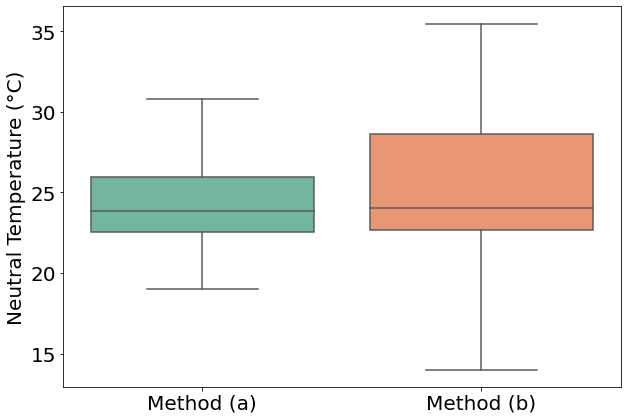

In [248]:
# boxplot of n_t_a in df_bldg_sig_a and n_t_b and in df_bldg_sig_b, don't show outliers

plt.figure(figsize=(10, 7))
sns.boxplot(data=[df_bldg_sig_a['n_t_a'], df_bldg_sig_b['n_t_b']], palette='Set2', showfliers=False)
# print boxplot summary statistics
print('n_t_a')
print(df_bldg_sig_a['n_t_a'].describe())
print('n_t_b')
print(df_bldg_sig_b['n_t_b'].describe())

plt.ylabel('Neutral Temperature (°C)', rotation=90, fontsize=20)
plt.xticks([0, 1], ['Method (a)', 'Method (b)'], fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.show()

n_t_a
count    70.000000
mean     24.289955
std       3.147114
min      19.021124
25%      22.052439
50%      23.966312
75%      26.418541
max      33.242804
Name: n_t_a, dtype: float64
n_t_b
count    149.000000
mean      26.865683
std        4.615842
min        6.316000
25%       23.930189
50%       27.931429
75%       30.307500
max       35.490000
Name: n_t_b, dtype: float64


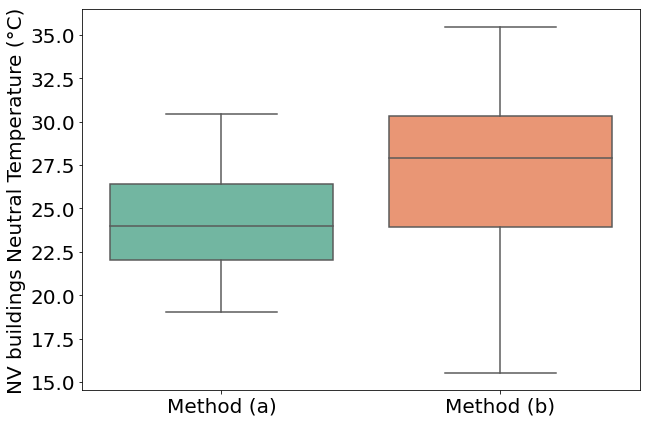

In [280]:
# NV buildings
plt.figure(figsize=(10, 7))
sns.boxplot(data=[df_bldg_nv_a['n_t_a'], df_bldg_nv_b['n_t_b']], palette='Set2', showfliers=False)
# print boxplot summary statistics
print('n_t_a')
print(df_bldg_nv_a['n_t_a'].describe())
print('n_t_b')
print(df_bldg_nv_b['n_t_b'].describe())

plt.ylabel('NV buildings Neutral Temperature (°C)', rotation=90, fontsize=20)
plt.xticks([0, 1], ['Method (a)', 'Method (b)'], fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.show()

n_t_a
count    85.000000
mean     23.926550
std       1.484819
min      21.535360
25%      22.979321
50%      23.860139
75%      24.345989
max      31.830522
Name: n_t_a, dtype: float64
n_t_b
count    146.000000
mean      23.194457
std        1.716078
min       12.775000
25%       22.685217
50%       23.335666
75%       23.909456
max       27.763548
Name: n_t_b, dtype: float64


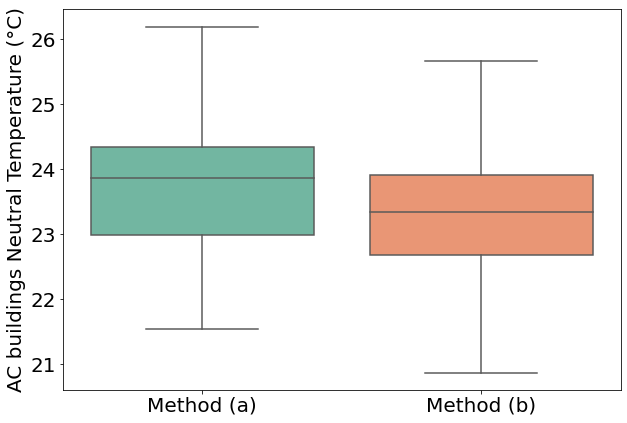

In [250]:
# AC buildings
plt.figure(figsize=(10, 7))
sns.boxplot(data=[df_bldg_ac_a['n_t_a'], df_bldg_ac_b['n_t_b']], palette='Set2', showfliers=False)
# print boxplot summary statistics
print('n_t_a')
print(df_bldg_ac_a['n_t_a'].describe())
print('n_t_b')
print(df_bldg_ac_b['n_t_b'].describe())

plt.ylabel('AC buildings Neutral Temperature (°C)', rotation=90, fontsize=20)
plt.xticks([0, 1], ['Method (a)', 'Method (b)'], fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.show()

acceptable temeprature range comparasion

t_80_up_a
count    210.000000
mean      27.668742
std        3.412919
min       21.911428
25%       25.163584
50%       26.524534
75%       29.920540
max       38.821606
Name: t_80_up_a, dtype: float64
t_80_up_b
count    419.000000
mean      25.847155
std        4.059909
min       13.100000
25%       23.155882
50%       24.749994
75%       29.530660
max       35.490000
Name: t_80_up_b, dtype: float64


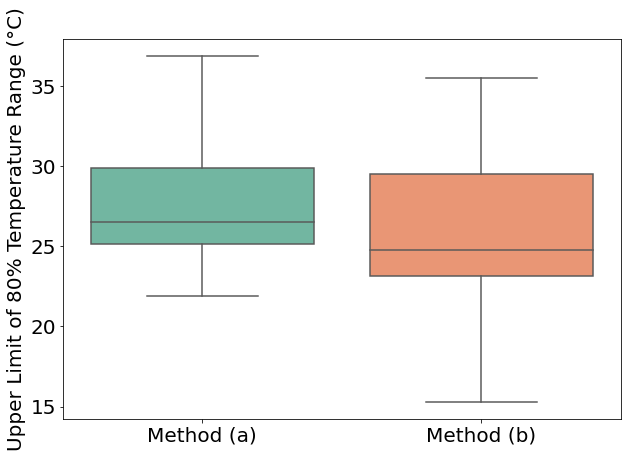

In [251]:
# boxplot of t_80_up_a in df_bldg_sig_a and t_80_up_b and in df_bldg_sig_b, don't show outliers

plt.figure(figsize=(10, 7))
sns.boxplot(data=[df_bldg_sig_a['t_80_up_a'], df_bldg_sig_b['t_80_up_b']], palette='Set2', showfliers=False)
# print boxplot summary statistics
print('t_80_up_a')
print(df_bldg_sig_a['t_80_up_a'].describe())
print('t_80_up_b')
print(df_bldg_sig_b['t_80_up_b'].describe())

plt.ylabel('Upper Limit of 80% Temperature Range (°C)', rotation=90, fontsize=20)
plt.xticks([0, 1], ['Method (a)', 'Method (b)'], fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.show()

t_80_low_a
count    210.000000
mean      21.185572
std        3.862306
min        4.465876
25%       19.191383
50%       21.601877
75%       23.125084
max       29.146479
Name: t_80_low_a, dtype: float64
t_80_low_b
count    419.000000
mean      24.193357
std        4.922602
min       -4.421200
25%       22.099099
50%       23.635752
75%       27.708662
max       35.490000
Name: t_80_low_b, dtype: float64


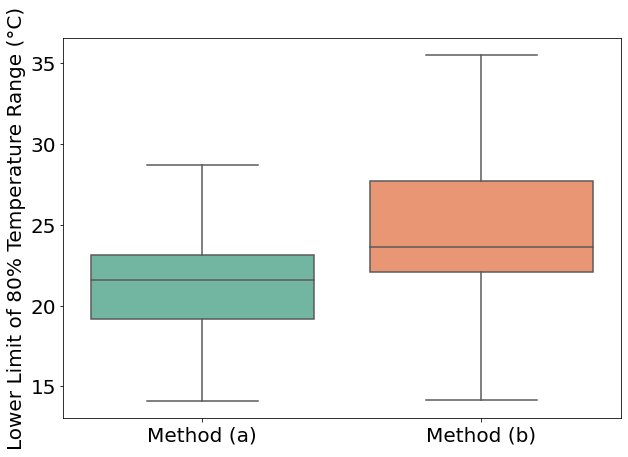

In [252]:
# boxplot of t_80_low_a in df_bldg_sig_a and t_80_low_b and in df_bldg_sig_b, don't show outliers

plt.figure(figsize=(10, 7))
sns.boxplot(data=[df_bldg_sig_a['t_80_low_a'], df_bldg_sig_b['t_80_low_b']], palette='Set2', showfliers=False)
# print boxplot summary statistics
print('t_80_low_a')
print(df_bldg_sig_a['t_80_low_a'].describe())
print('t_80_low_b')
print(df_bldg_sig_b['t_80_low_b'].describe())

plt.ylabel('Lower Limit of 80% Temperature Range (°C)', rotation=90, fontsize=20)
plt.xticks([0, 1], ['Method (a)', 'Method (b)'], fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.show()

t_80_diff_a
count    210.000000
mean       6.483170
std        4.550449
min        0.034000
25%        3.419248
50%        5.435545
75%        8.369759
max       29.110494
Name: t_80_diff_a, dtype: float64
t_80_diff_b
count    419.000000
mean       1.653798
std        2.858450
min        0.000000
25%        0.220282
50%        0.701523
75%        2.082594
max       26.422250
Name: t_80_diff_b, dtype: float64


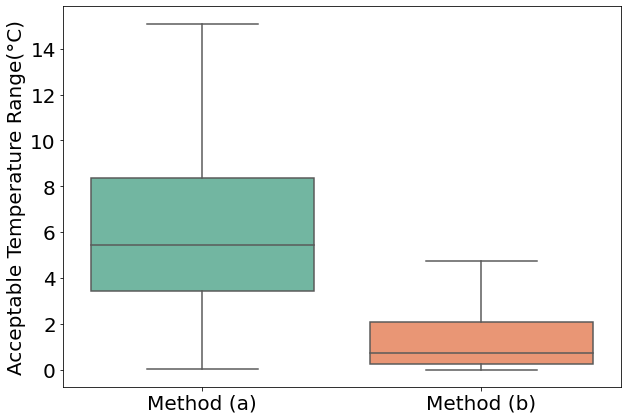

In [253]:
# boxplot of t_80_diff_a in df_bldg_sig_a and t_80_diff_b in df_bldg_sig_b, don't show outliers
plt.figure(figsize=(10, 7))
sns.boxplot(data=[df_bldg_sig_a['t_80_diff_a'], df_bldg_sig_b['t_80_diff_b']], palette='Set2', showfliers=False)
# print boxplot summary statistics
print('t_80_diff_a')
print(df_bldg_sig_a['t_80_diff_a'].describe())
print('t_80_diff_b')
print(df_bldg_sig_b['t_80_diff_b'].describe())

plt.ylabel('Acceptable Temperature Range(°C)', rotation=90, fontsize=20)
plt.xticks([0, 1], ['Method (a)', 'Method (b)'], fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.show()


In [ ]:
# how many buildings have a negative coefficient for the regression of thermal sensation against temperature


## Adaptive comfort model (natural ventilated buildings?)

### Weighted regression function

In [254]:
def weighted_regression(x, y, weights):
    X = sm.add_constant(x)
    model = sm.WLS(y, X, weights=weights).fit()
    intercept, slope = model.params
    # print p value of slope
    print('the p value of slope is {:.3f}'.format(model.pvalues[1]))
    print('the weigted regression fitted line slope (a) a is {:.2f}'.format(slope))
    print('the weigted regression fitted line intercept (b) is {:.2f}'.format(intercept))
    return intercept, slope

In [255]:
print("neutral temperature line")
weighted_regression(df_bldg_nv_a['t_out_combined'], df_bldg_nv_a['n_t_a'], df_bldg_nv_a['records'])

neutral temperature line
the p value of slope is 0.000
the weigted regression fitted line slope (a) a is 0.29
the weigted regression fitted line intercept (b) is 18.00


(17.998538214485933, 0.2909233476943448)

method a

In [267]:
up_a_intercept, up_a_slope = weighted_regression(df_bldg_nv_a['t_out_combined'], df_bldg_nv_a['t_80_up_a'], df_bldg_nv_a['records'])
low_a_intercept, low_a_slope= weighted_regression(df_bldg_nv_a['t_out_combined'], df_bldg_nv_a['t_80_low_a'], df_bldg_nv_a['records'])

the p value of slope is 0.000
the weigted regression fitted line slope (a) a is 0.25
the weigted regression fitted line intercept (b) is 22.76
the p value of slope is 0.000
the weigted regression fitted line slope (a) a is 0.33
the weigted regression fitted line intercept (b) is 13.24


In [277]:
up_a_slope*df_bldg_nv_a['t_out_combined']+up_a_intercept

60     29.404783
61     29.103328
62     29.135325
63     29.276961
84     27.676383
         ...    
524    26.660775
533    26.941490
534    25.748399
551    25.247033
552    24.593821
Name: t_out_combined, Length: 70, dtype: float64

(14.0, 32.0)

<Figure size 720x504 with 0 Axes>

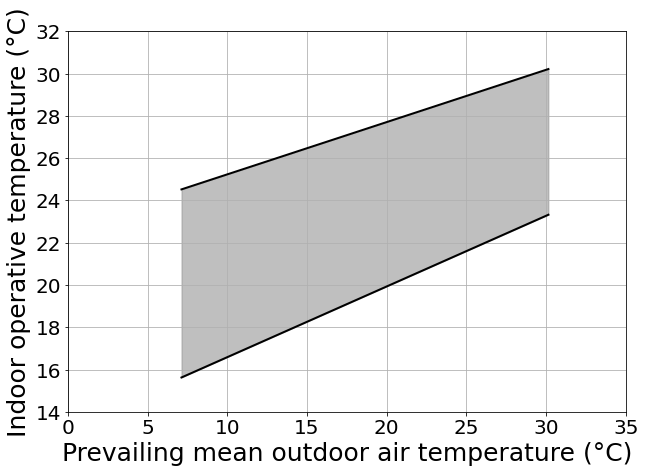

In [320]:
# plot two lines, one with the up_a_slope and up_a_intercept, and another with the low_a_slope and low_a_intercept
plt.figure(figsize=(10, 7))
t_out_combined = np.array(df_bldg_nv_a['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = (up_a_slope*t_out_combined + up_a_intercept)[sort_index]
low_line = (low_a_slope*t_out_combined + low_a_intercept)[sort_index]

# draw grey band between the two lines
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, up_a_slope*t_out_combined+up_a_intercept, color='black', linewidth=2)
plt.plot(t_out_combined, low_a_slope*t_out_combined+low_a_intercept, color='black', linewidth=2)
plt.fill_between(t_out_combined, up_a_slope*t_out_combined+up_a_intercept, low_a_slope*t_out_combined+low_a_intercept, color='grey', alpha=0.5)
plt.xlabel('Prevailing mean outdoor air temperature (°C)', fontsize=25)
plt.ylabel('Indoor operative temperature (°C)', rotation=90, fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)

# set the x-axis range from 5 to 35 and y-axis range from 14 to 32
plt.xlim(0, 35)
plt.ylim(14, 32)


method b

In [290]:
up_b_intercept, up_b_slope = weighted_regression(df_bldg_nv_b['t_out_combined'], df_bldg_nv_b['t_80_up_b'], df_bldg_nv_b['records'])
low_b_intercept, low_b_slope= weighted_regression(df_bldg_nv_b['t_out_combined'], df_bldg_nv_b['t_80_low_b'], df_bldg_nv_b['records'])

the p value of slope is 0.000
the weigted regression fitted line slope (a) a is 0.46
the weigted regression fitted line intercept (b) is 16.47
the p value of slope is 0.000
the weigted regression fitted line slope (a) a is 0.42
the weigted regression fitted line intercept (b) is 15.95


(14.0, 32.0)

<Figure size 720x504 with 0 Axes>

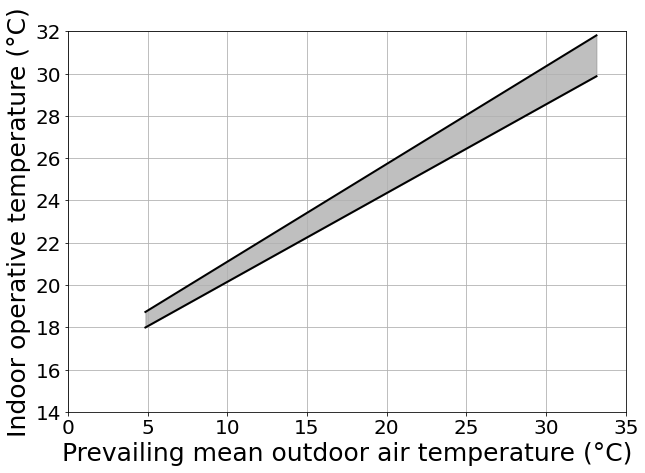

In [321]:
# plot two lines, one with the up_b_slope and up_b_intercept, and another with the low_b_slope and low_b_intercept
plt.figure(figsize=(10, 7))
t_out_combined = np.array(df_bldg_nv_b['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = (up_b_slope*t_out_combined + up_b_intercept)[sort_index]
low_line = (low_b_slope*t_out_combined + low_b_intercept)[sort_index]

# draw grey band between the two lines
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, up_b_slope*t_out_combined+up_b_intercept, color='black', linewidth=2)
plt.plot(t_out_combined, low_b_slope*t_out_combined+low_b_intercept, color='black', linewidth=2)
plt.fill_between(t_out_combined, up_b_slope*t_out_combined+up_b_intercept, low_b_slope*t_out_combined+low_b_intercept, color='grey', alpha=0.5)
plt.xlabel('Prevailing mean outdoor air temperature (°C)', fontsize=25)
plt.ylabel('Indoor operative temperature (°C)', rotation=90, fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
# set the x-axis range from 5 to 35 and y-axis range from 14 to 32
plt.xlim(0, 35)
plt.ylim(14, 32)



In [293]:
# print the range of t_out_combined
print('the range of t_out_combined is ({:.1f}'.format(df_bldg_nv_b['t_out_combined'].min()), '~ {:.1f})'.format(df_bldg_nv_b['t_out_combined'].max()))

the range of t_out_combined is (4.9 ~ 33.2)
